## Introdução

O objetivo deste projeto é construir um modelo para prever a idade dos usuários de um aplicativo a partir da foto de perfil, tendo o valor da métrica MAE inferior a 5 durante o treinamento e inferior a 10 para o conjunto de validação.

A métrica MAE foi escolhida por ser uma medida de desempenho recomendada em problemas de regressão (neste caso a previsão da idade), quanto menor for o valor melhor será o desempenho do modelo.

Um MAE de 5.0 significa que o modelo deverá prever a idade em uma margem de erro de até ± 5 anos em relação à idade real.

#### Ojetivos
* Prever idade baseado na foto do perfil
* MAE ≤ 5.0 (dados de treino)
* MAE ≤ 10 (dados de validação)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load data

In [3]:
labels = pd.read_csv('datasets/age_classification/labels.csv')

In [4]:
data_gen = ImageDataGenerator(rescale=1./255)

In [5]:
training_photos = data_gen.flow_from_dataframe(
        dataframe=labels,
        directory='datasets/age_classification/photos/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
)

Found 7591 validated image filenames.


In [6]:
X, y = next(training_photos)

## Data overview

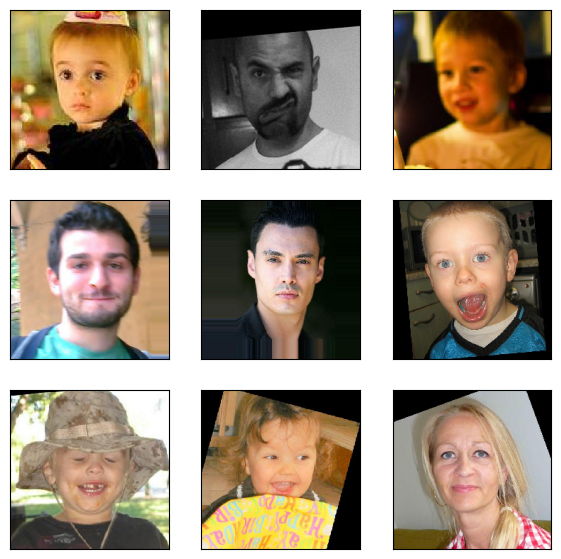

In [7]:
fig = plt.figure(figsize=(7,7))

for i in range(9):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(X[i + 10])
    plt.xticks([])
    plt.yticks([])

#### Conclusões
As fotos não estão padronizadas (rotação, escala, posição rosto)
* talvez será necessário aplicar técnicas de data-augmentation para melhorar a performance do modelo escolhido

## EDA
A seguir será verificada a distribuição das idades em todo o conjunto, visando identificar onde estão concentrados a maior parte dos dados, e caso necessário, realizar alterações, e adequações dos mesmos.

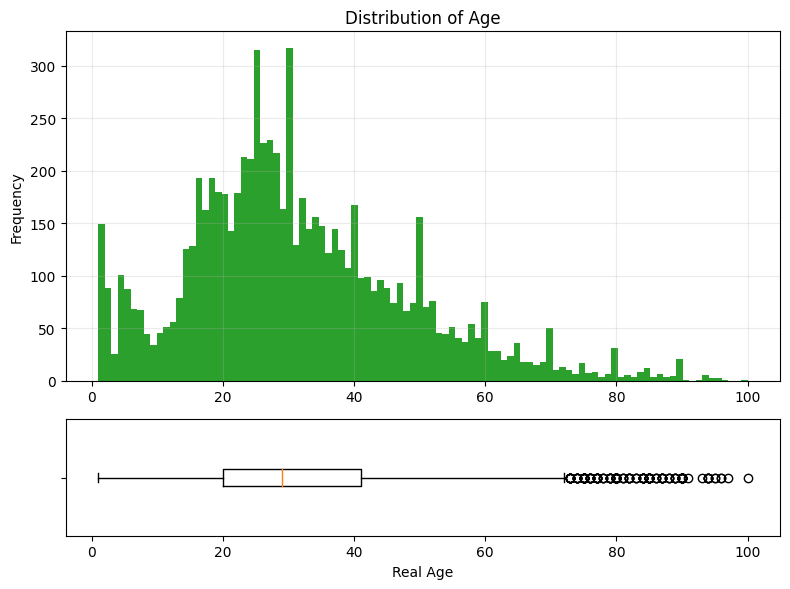

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})

ax1.hist(labels['real_age'], bins=100, color='C2', alpha=1)
ax1.set_title('Distribution of Age')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.25)

ax2.boxplot(labels['real_age'], vert=False)
ax2.set_xlabel('Real Age')
ax2.set_yticklabels([])

plt.tight_layout()

In [9]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


#### Conclusões
* Maior concentração de pessoas na faixa dos 20~40 anos de idade
* Poucos exemplos de pessoas com mais de 70 anos

## Modeling
A seguir será realizada a construção do modelo de aprendizado de máquina, específico para lidar com imagens. Por se tratar de um problema de regressão (prever a idade), a métrica adotada será o MAE, tanto no conjunto de treino quanto no conjunto de testes. Isso vai garantir a precisão e confiabilidade do modelo em novas imagens.

#### Objetivos:
* MAE ≤ 5.0 (dados de treino)
* MAE ≤ 10 (dados de validação)

In [13]:
# split data train and valid datasets
train_df, valid_df = train_test_split(labels, test_size=0.2, random_state=42)

In [14]:
data_gen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

In [15]:
train_datagen_flow = data_gen.flow_from_dataframe(
        dataframe=train_df,
        directory='datasets/age_classification/photos/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
)

Found 6072 validated image filenames.


In [16]:
data_gen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

In [17]:
val_datagen_flow = data_gen.flow_from_dataframe(
        dataframe=valid_df,
        directory='datasets/age_classification/photos/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
)

Found 1519 validated image filenames.


In [18]:
# model creation and parameter settings
optimizer = Adam(learning_rate=0.0003)

backbone = ResNet50(
    input_shape=(224, 224, 3), 
    weights='imagenet', 
    include_top=False
)

model = Sequential()
model.add(backbone)
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu')) 
model.compile(optimizer=optimizer, loss='mae', metrics=['mae']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model.fit(
    train_datagen_flow,
    validation_data=val_datagen_flow,
    steps_per_epoch=len(train_datagen_flow),
    validation_steps=len(val_datagen_flow),
    epochs=20,
)

Epoch 1/20
190/190 [==============================] - 1884s 10s/step - loss: 10.4407 - mae: 10.4407 - val_loss: 17.7788 - val_mae: 17.7788
Epoch 2/20
190/190 [==============================] - 1870s 10s/step - loss: 7.7205 - mae: 7.7205 - val_loss: 15.9341 - val_mae: 15.9341
Epoch 3/20
190/190 [==============================] - 1870s 10s/step - loss: 6.6197 - mae: 6.6197 - val_loss: 12.8077 - val_mae: 12.8077
Epoch 4/20
190/190 [==============================] - 1861s 10s/step - loss: 5.9758 - mae: 5.9758 - val_loss: 10.6925 - val_mae: 10.6925
Epoch 5/20
190/190 [==============================] - 1874s 10s/step - loss: 5.3074 - mae: 5.3074 - val_loss: 8.4598 - val_mae: 8.4598
Epoch 6/20
190/190 [==============================] - 1866s 10s/step - loss: 4.8193 - mae: 4.8193 - val_loss: 8.5352 - val_mae: 8.5352
Epoch 7/20
190/190 [==============================] - 1848s 10s/step - loss: 4.6008 - mae: 4.6008 - val_loss: 7.4161 - val_mae: 7.4161
Epoch 8/20
190/190 [=========================

In [ ]:
# Save the model
model.save("models/final_model")

## Conclusões
Os dados foram carregados e o modelo foi treinado com sucesso MAE ≅ 2.8 (treino) e 6.7 (validação), bastante inferior aos valores esperados, atigindo os objetivos anteriormente estabelecidos.
#### Idade no conjunto de dados
A maior parte das imagens disponíveis são de pessoas na faixa dos 20~40 anos de idade. Foi também observado que há poucas fotos de pessoas acima dos 70 anos, além de uma alta concentração de crianças com menos de 10 anos.

#### Desempenho do modelo
* MAE treino ≅ 2.8
* MAE validação ≅ 6.7